In [104]:
import numpy as np
from sklearn import datasets
import torch
import torch.nn as nn
import torch.optim as optim
import torchbnn as bnn
import matplotlib.pyplot as plt
from src.features import build_features as f
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, log_loss


%matplotlib inline

In [260]:
vladdy = 665489
soto = 665742
schneider = 676914
biggio = 624415
showtime = 660271
crowser = 681297

batter = vladdy


X_train, y_train, X_test, y_test, encoders = f.get_pitch_outcome_dataset_xgb(batter, split=True)

In [261]:
from src.data.data_utils import query_mlb_db
batter_id = crowser
data = query_mlb_db(f'''
select 
            case
                when description='swinging_strike' or description='swinging_strike_blocked' or description='called_strike' or description='foul_tip' 
                    or description='swinging_pitchout' then 'strike'
                when description='foul' or description='foul_pitchout' then 'foul'
                when description='ball' or description='blocked_ball' or description='pitchout' then 'ball'
                when description='hit_by_pitch' then 'hit_by_pitch'
                when description='hit_into_play' then 'hit_into_play'
                else NULL
            end as pitch_outcome,

            p_throws,
            
            pitch_number, strikes, balls,
            
            release_speed, 
            release_spin_rate, 
            release_extension,

            release_pos_x,
            release_pos_y,
            release_pos_z,
            
            spin_axis,
            pfx_x, pfx_z, 
            
            vx0, vy0, vz0,
            ax, ay, az,
            plate_x, plate_z
            
        from Statcast
        where batter={batter_id}
        /* and game_pk in (
                select distinct game_pk
                from Statcast
                where batter = {batter_id}
                order by game_date desc
                limit 324
        ) */
        and pitch_outcome & p_throws & pitch_number & strikes & balls &
            release_speed &
            release_spin_rate &
            release_extension &

            release_pos_x &
            release_pos_y &
            release_pos_z &
            
            spin_axis &
            pfx_x & pfx_z &
            
            vx0 & vy0 & vz0 &
            ax & ay & az &
            plate_x & plate_z
        is not null
        order by game_date asc, at_bat_number asc, pitch_number asc;
''')



In [262]:
data = data[['pitch_outcome', 'p_throws', 'strikes', 'balls', 'release_speed', 'release_spin_rate', 'plate_x', 'plate_z']]

In [263]:
# Define features and target
features = data.drop(columns=['pitch_outcome'])
target = data['pitch_outcome']


label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(target)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features, y_encoded, test_size=0.2, shuffle=False)

In [264]:
X_train

,p_throws,strikes,balls,release_speed,release_spin_rate,plate_x,plate_z
0,R,0,0,91.4,2397,-0.70,3.17
1,R,1,0,91.2,2382,0.70,3.50
2,R,1,1,84.3,1905,0.23,1.78
3,R,2,1,84.9,1789,-0.24,1.05
4,R,0,0,82.8,2428,1.44,1.32
...,...,...,...,...,...,...,...
913,R,2,2,96.2,2334,-0.15,2.79
914,R,2,2,82.9,2484,0.47,2.81
915,R,0,0,94.2,2283,-0.77,2.01
916,R,1,0,84.2,2131,-0.36,2.24


In [265]:
# Preprocessing pipeline
numeric_features = features.select_dtypes(include=['float64', 'int64']).columns
categorical_features = features.select_dtypes(include=['object']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

import xgboost as xgb
from sklearn.metrics import classification_report, log_loss

# Train the model
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb.XGBClassifier(n_estimators=25, eval_metric='mlogloss'))
])

# Train the model
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)

print(classification_report(label_encoder.inverse_transform(y_test), label_encoder.inverse_transform(y_pred)))
print('Log Loss:', log_loss(y_test, y_prob))

               precision    recall  f1-score   support

         ball       0.79      0.88      0.83        88
         foul       0.29      0.24      0.27        45
 hit_by_pitch       0.00      0.00      0.00         1
hit_into_play       0.25      0.17      0.20        29
       strike       0.50      0.55      0.52        67

     accuracy                           0.57       230
    macro avg       0.37      0.37      0.36       230
 weighted avg       0.53      0.57      0.55       230

Log Loss: 1.0214223187100118


/home/colclour/miniconda3/envs/mlb/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/colclour/miniconda3/envs/mlb/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/colclour/miniconda3/envs/mlb/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

In [266]:
label_encoder.inverse_transform(list(range(5)))

array(['ball', 'foul', 'hit_by_pitch', 'hit_into_play', 'strike'],
      dtype=object)

In [173]:
#log loss 0.897 with 5 vars
#snched 1.022

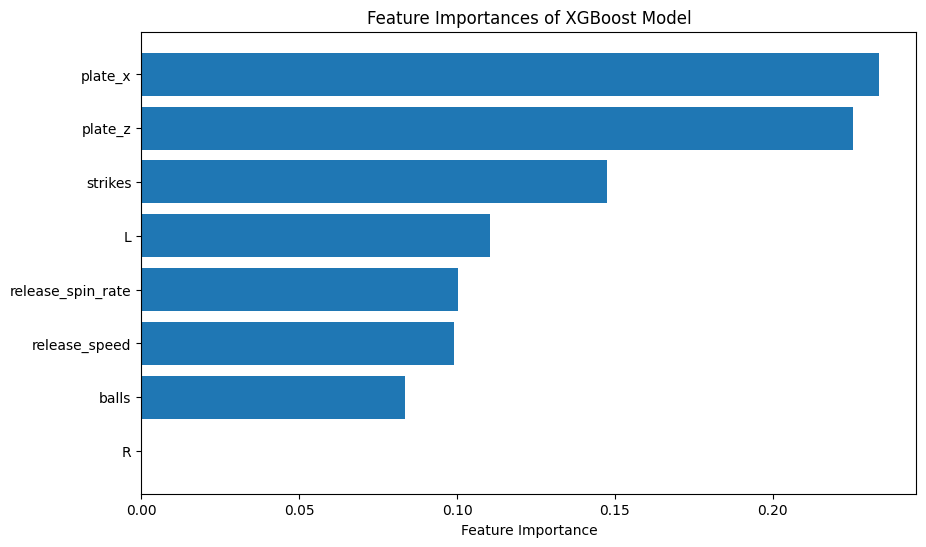

Log Likelihood (Log Loss): 1.0214223187100118


In [267]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import log_loss

# Extract the trained XGBoost model from the pipeline
xgb_model = model.named_steps['classifier']

# Get feature names after preprocessing
onehot_categories = model.named_steps['preprocessor'].named_transformers_['cat'].categories_
onehot_feature_names = np.concatenate(onehot_categories)
feature_names = np.concatenate([numeric_features, onehot_feature_names])
#feature_names = numeric_features

# Plot feature importances
importance = xgb_model.feature_importances_
sorted_idx = np.argsort(importance)

plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), feature_names[sorted_idx])
plt.xlabel('Feature Importance')
plt.title('Feature Importances of XGBoost Model')
plt.show()

# Compute log likelihood (log loss)
y_prob = model.predict_proba(X_test)
log_likelihood = log_loss(y_test, y_prob)

print('Log Likelihood (Log Loss):', log_likelihood)


In [242]:
model.predict_proba(X_train)

array([[0.07542545, 0.1394123 , 0.00322401, 0.15980217, 0.62213606],
       [0.92866606, 0.02495675, 0.00145642, 0.01528813, 0.02963264],
       [0.03761526, 0.2800743 , 0.00419078, 0.10591669, 0.572203  ],
       ...,
       [0.70596784, 0.0277673 , 0.00285659, 0.03606213, 0.22734609],
       [0.8040941 , 0.07027993, 0.00300566, 0.07312936, 0.04949096],
       [0.01920201, 0.24298808, 0.00326522, 0.17741074, 0.557134  ]],
      dtype=float32)

In [268]:
def sample_predictions(classifier, X):
    pred_proba = classifier.predict_proba(X)
    sampled_predictions = np.array([np.random.choice(classifier.classes_, p=proba) for proba in pred_proba])

    return sampled_predictions

In [270]:
def categorical_chisquare():
    sampled_preds = sample_predictions(model, X_test)
    pred_counts = pd.DataFrame(label_encoder.inverse_transform(sampled_preds)).value_counts()
    actual_counts = pd.DataFrame(label_encoder.inverse_transform(y_test)).value_counts()
    
    from scipy.stats import chisquare
    
    # Align the indices of both counts
    pred_counts = pred_counts.reindex(actual_counts.index, fill_value=0)
    
    # Perform chi-square goodness-of-fit test
    chi2_stat, p_value = chisquare(f_obs=actual_counts, f_exp=pred_counts)
    
    print("Chi-square statistic:", chi2_stat)
    print("p-value:", p_value)
    
    # Interpretation of the result
    if p_value < 0.05:
        print("The distributions are significantly different (reject the null hypothesis).")
    else:
        print("The distributions are not significantly different (fail to reject the null hypothesis).")

Chi-square statistic: 2.6848927732079906
p-value: 0.611860759819182
The distributions are not significantly different (fail to reject the null hypothesis).
